In [37]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, GridSearchCV
import matplotlib.pyplot as plt



In [38]:
with open('features_config.json', 'r') as f:
    features_config = json.load(f)
features_config

{'numeric_columns': ['feature2', 'feature5', 'feature13', 'feature18'],
 'category_columns': ['feature1',
  'feature3',
  'feature4',
  'feature6',
  'feature7',
  'feature8',
  'feature9',
  'feature10',
  'feature11',
  'feature12',
  'feature14',
  'feature15',
  'feature16',
  'feature17',
  'feature19',
  'feature20'],
 'target_column': 'label',
 'ml_type': 'classification'}

In [39]:
train_data = pd.read_parquet('raw_train.parquet')

In [40]:
train_data.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,label
0,V1,4.781942,V2,V8,1337.025331,V4,V4,2.0,V2,V0,...,V2,35.689494,none,V1,1.0,V2,1.0,none,yes,0
1,V3,22.764682,V4,V2,1664.415301,V0,V4,4.0,V1,V0,...,V0,23.265980,none,V1,2.0,V2,1.0,none,yes,0
2,V3,7.462099,V2,V3,750.653224,V3,V2,4.0,V2,V0,...,V2,34.060872,stores,V0,1.0,V2,1.0,yes,yes,0
3,V3,23.718364,V4,V7,4829.002078,V4,V2,4.0,V1,V0,...,V3,62.477448,none,V1,2.0,V1,1.0,none,yes,0
4,V3,13.768903,V3,V3,3559.956292,V3,V4,1.0,V1,V0,...,V2,41.999120,bank,V1,1.0,V2,1.0,yes,yes,0


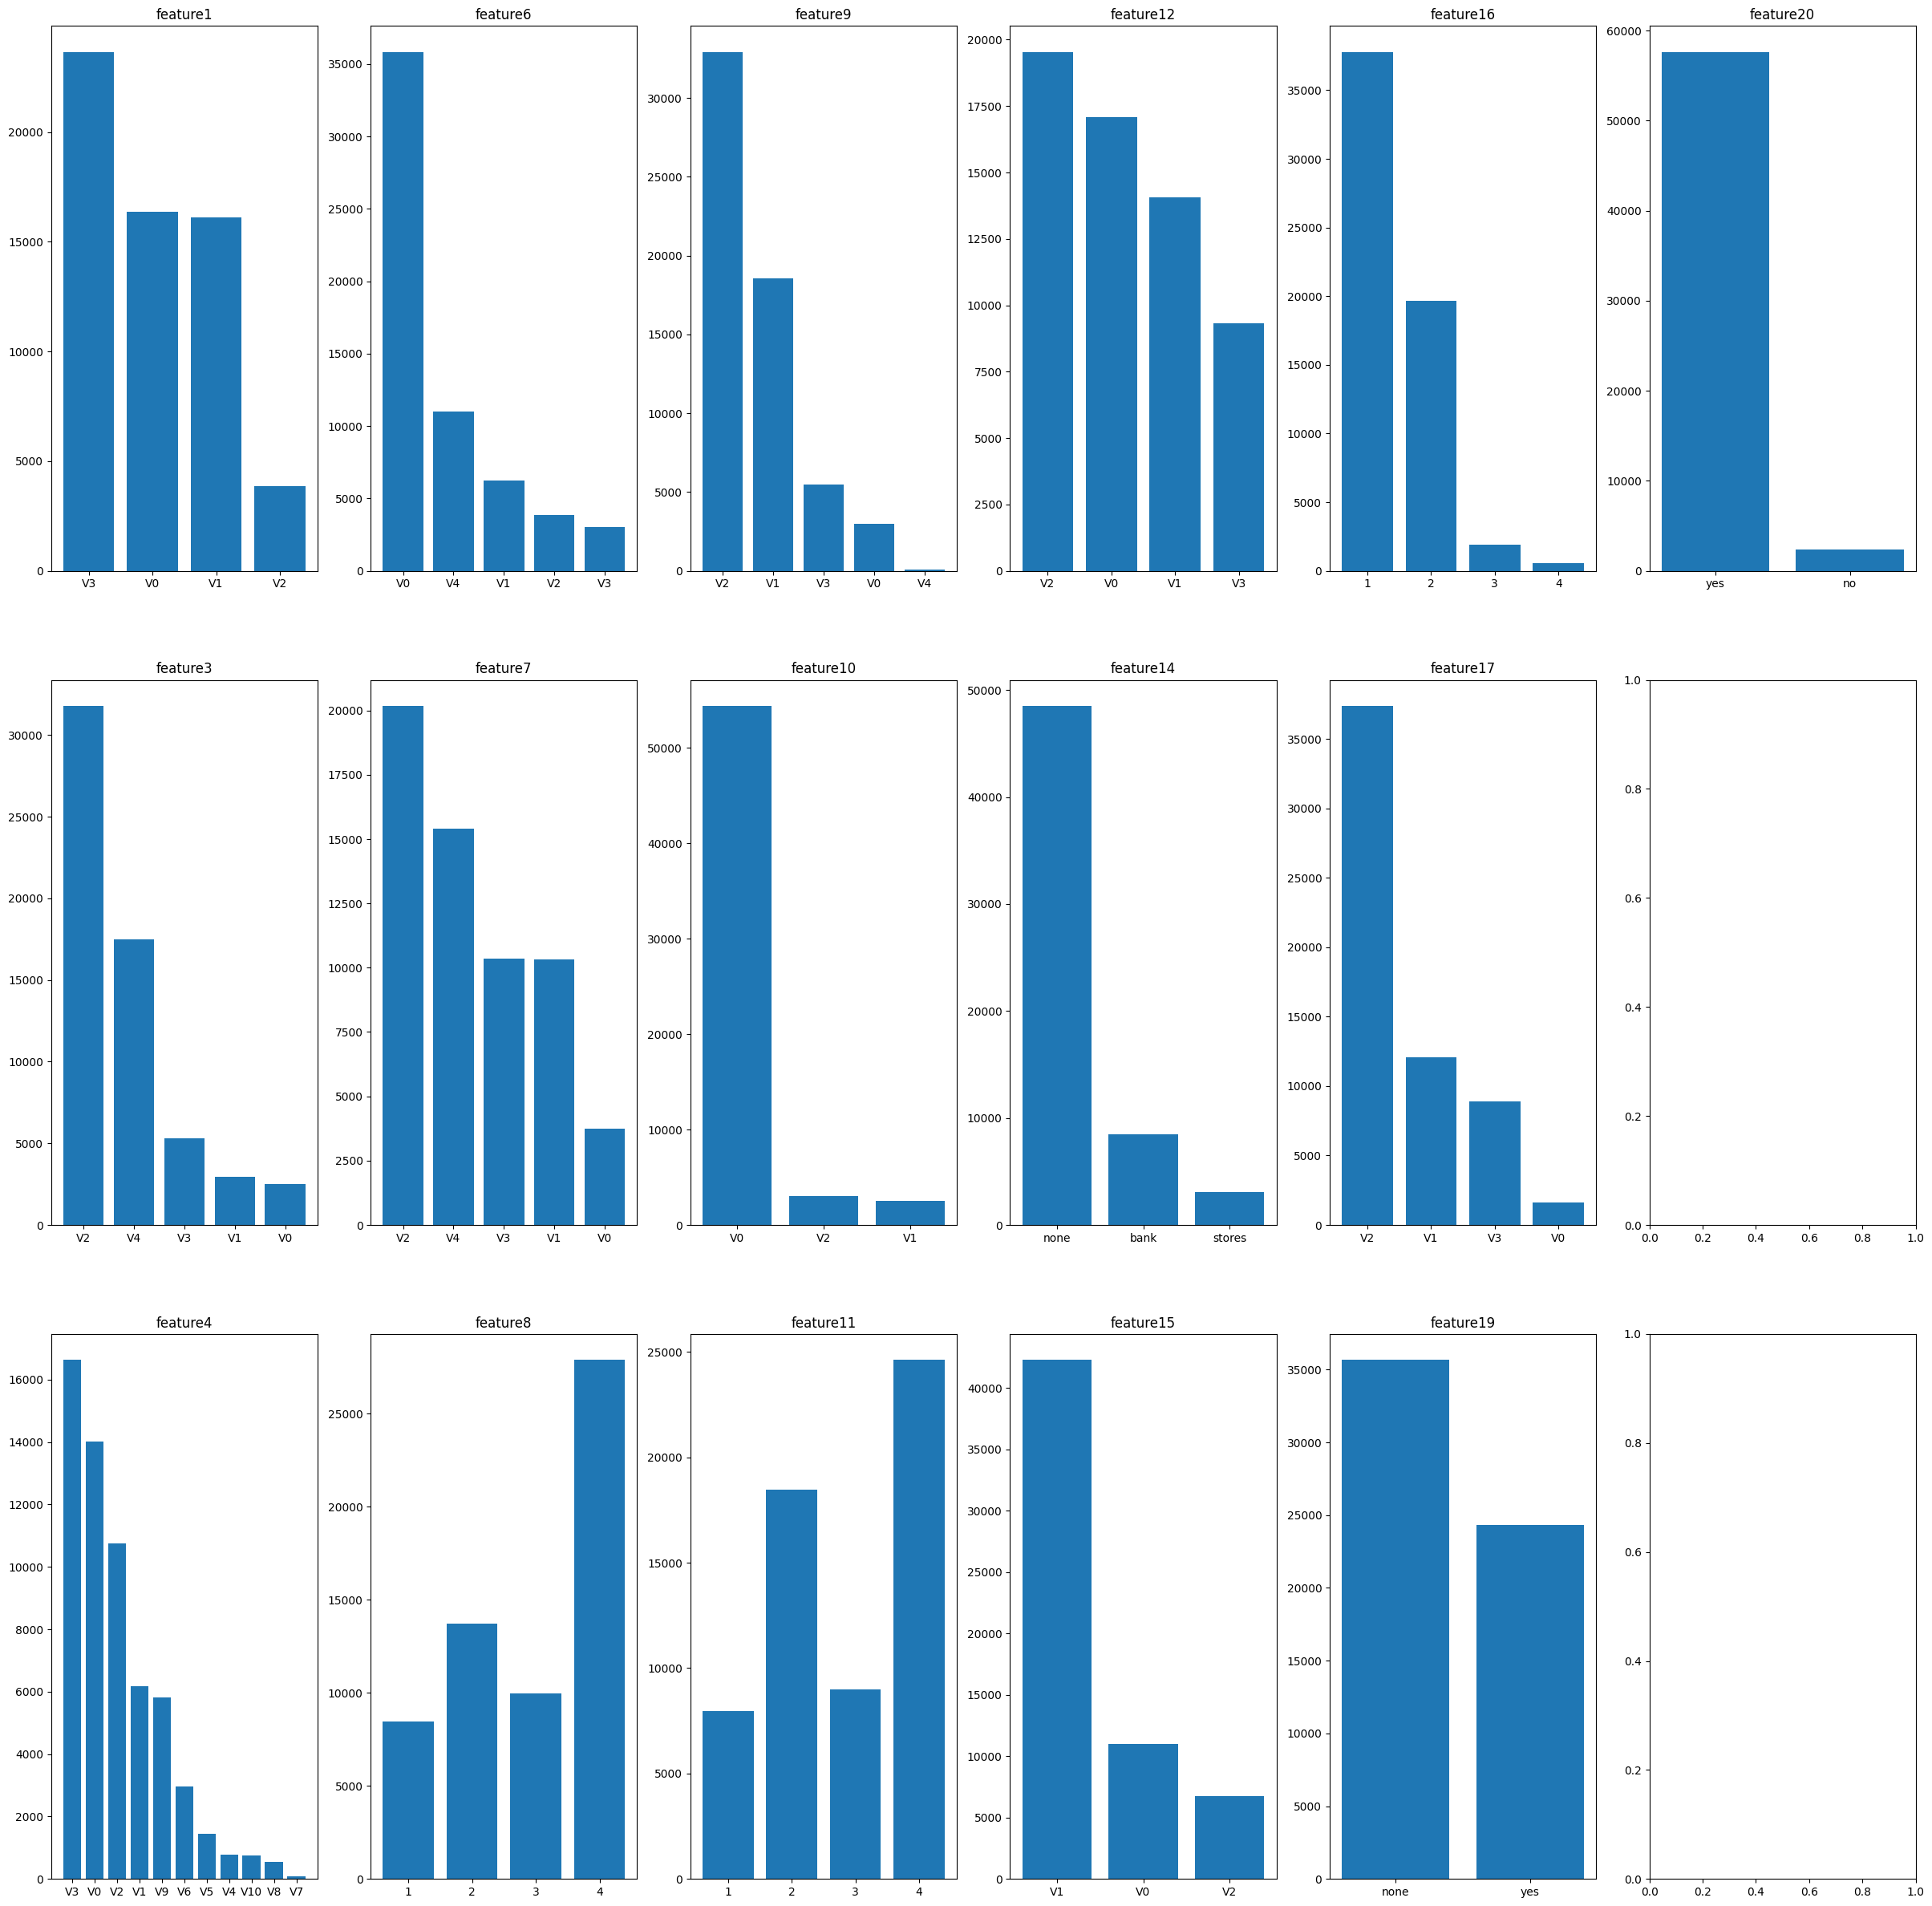

In [41]:
n_cat = len(features_config['category_columns'])
n_col = 3
n_row = n_cat // 3 + 1
fig, ax = plt.subplots(n_col, n_row, figsize=(30,30))
for i, feature_name in enumerate(features_config['category_columns']):
    x = i % n_col
    y = i // n_col
    data = train_data[feature_name].value_counts().to_dict()
    ax[x, y].bar(data.keys(), data.values())
    ax[x, y].set_title(feature_name)
plt.show()

In [42]:
X = train_data.drop('label', axis=1)
y = train_data.label

In [43]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
np.random.seed(0)

In [44]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Perform arbitary transformation
        X = X.drop('features')
        return X

In [45]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler()),
           ('pca', PCA())
           ]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_config['numeric_columns']),
        ("cat", categorical_transformer, features_config['category_columns']),
    ]
)

In [46]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBClassifier())]
)

In [47]:
step_pca = X.shape[1]//3
param_grid = {
    'preprocessor__num__pca__n_components': np.arange(1, len(features_config['numeric_columns']), step_pca),
    'model__max_depth': [2, 3, 5, 7],
    'model__n_estimators': [10, 25, 50],
}
grid = GridSearchCV(clf, param_grid, cv=2, n_jobs=-1, scoring='roc_auc', verbose=4)


In [48]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
grid.fit(X, y)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA())]),
                                                                         ['feature2',
                                                                          'feature5',
                                         

In [50]:
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

grid.best_params_, mean_score, std_score

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__max_depth': 5, 'model__n_estimators': 50, 'preprocessor__num__pca__n_components': 1}
Mean CV score:  0.842464
Standard deviation of CV score:  0.001192


In [51]:
# y_pred = grid.predict(X_test)
# p = precision_score(y_test, y_pred)
# r = recall_score(y_test, y_pred)
# roc = roc_auc_score(y_test, y_pred)

In [52]:
# p, r, roc

In [53]:
import pickle
model_path = 'prob_2.ckpt'
pickle.dump(grid.best_estimator_, open(model_path, 'wb'))